In [10]:
import graphlab as gl
import pandas as pd
import numpy as np
import scipy.stats.stats as stats
#%load_ext rpy2.ipython
import itertools
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics, preprocessing, datasets   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Performing grid search
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import LabelKFold
from sklearn.cross_validation import LeaveOneLabelOut
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 8
import sys
import pickle
from graphlab.util import cloudpickle
import graphlab.aggregate as agg
from math import sqrt

In [11]:
# Load the data
data =  gl.SFrame.read_csv('/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/data/dmsTraining_2017-02-20.csv')

Finished parsing file /net/fowler/vol1/home/vegray/metaDMS/dato/scaled/data/dmsTraining_2017-02-20.csv

Parsing completed. Parsed 100 lines in 2.92888 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,str,str,int,int,str,str,str,str,str,float,str,str,str,str,int,str,str,str,str,str,float,float,float,int,int,int,float,float,float,int,float,float,float,float,str,str,float,float,float,str,float,float,float,float,int,float,str,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /net/fowler/vol1/home/vegray/metaDMS/dato/scaled/data/dmsTraining_2017-02-20.csv

Parsing completed. Parsed 101460 lines in 1.41907 secs.

In [12]:
## Use predictors3
predictors3 = ['aa1', 'aa2', 'wt_mut', 'aa1_polarity', 
               'aa2_polarity', 'aa1_PI', 'aa2_PI', 'deltaPI', 
               'Grantham', 'aa1_weight', 'aa2_weight', 'deltaWeight',
               'aa1vol', 'aa2vol', 'deltavolume', 'aa1_psic',
               'aa2_psic', 'delta_psic',  'accessibility',
               'dssp_sec_str', 'phi_psi_reg', 'delta_solvent_accessibility',
               'b_factor', 'mut_msa_congruency', 'mut_mut_msa_congruency', 
               'seq_ind_closest_mut',  'evolutionary_coupling_avg']

In [13]:
## Global model dataset cleanup
data2 = data.filter_by([x for x in data['dms_id'].unique() if x not in ['CcdB','beta-lactamase_2500', 'beta-lactamase_0', 
                                                                                      'kka2_1:1','kka2_1:4','kka2_1:8',
                                                                     'beta-lactamase_39', 'gal4','hemagglutinin', 'np',
                                                                                      'dbr1', 'beta-lactamase_156',
                                                                                      'beta-lactamase_625', 'ERK2','GFP',
                                                                                      'Brca1_HDR', ]], 'dms_id')
#data2 = data2[(data2['binary_mut_type_prob'] < 0.4) | (data2['binary_mut_type_prob'] > 0.6)]
data2 = data2.filter_by([x for x in data2['mut_type'].unique() if x in ['missense']], 'mut_type')
#del data2['id']
#data2 = data2.add_row_number('id',0)

In [18]:
len(data2['dms_id'])
data2.to_dataframe().groupby(['dms_id','position']).count()

,,id,id3,variant_id,first_author,protein_size,assay_type,organism,uniprot_id,pdb_id,pdb_chain_id,...,seq_ind_closest_mut,scaled_effect1,selection_coefficient,evolutionary_coupling_avg,evolutionary_coupling_prop,evolutionary_coupling_avg_norm,discrete,discrete_dam,discrete_neutral,discrete_enhancing
dms_id,protein,,,,,,,,,,,,,,,,,,,,,
Brca1_E3,Brca1,4872,4872,4872,4872,4872,4872,4872,4872,4872,4872,...,4215,4872,4872,4872,4872,4872,0,4872,4872,4872
Brca1_Y2H,Brca1,1748,1748,1748,1748,1748,1748,1748,1748,1748,1748,...,1346,1748,1748,1748,1748,1748,0,1748,1748,1748
E1_Ubiquitin,UBI4,1085,1085,1085,1085,1085,1085,1085,1085,1085,1085,...,917,1085,1085,1085,1085,1085,1085,1085,1085,1085
E3_ligase,E3_ligase,899,899,899,899,899,899,899,899,899,899,...,83,899,899,888,888,888,0,899,899,899
PSD95pdz3,PSD95pdz3,1577,1577,1577,1577,1577,1577,1577,1577,1577,1577,...,190,1577,1577,1577,1577,1577,0,1577,1577,1577
Pab1,Pab1,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188,...,743,1188,1188,1188,1188,1188,1188,1188,1188,1188
Ubiquitin,UBI4,1249,1249,1249,1249,1249,1249,1249,1249,1249,1249,...,1249,1249,1249,1249,1249,1249,1249,1249,1249,1249
WW_domain,Yap65,363,363,363,363,363,363,363,363,363,363,...,269,363,363,363,363,363,363,363,363,363
beta-lactamase,TEM-1,5198,5198,5198,5198,5198,5198,5198,5198,5198,5198,...,4991,5198,5198,5180,5180,5180,5198,5198,5198,5198


In [4]:
data2.column_names()

['id3',
 'variant_id',
 'dms_id',
 'first_author',
 'protein',
 'id',
 'snap2score',
 'protein_size',
 'assay_type',
 'organism',
 'uniprot_id',
 'pdb_id',
 'pdb_chain_id',
 'reported_fitness',
 'aa1',
 'aa2',
 'wt_mut',
 'mut_type',
 'position',
 'id2',
 'WT_Mut',
 'Variant',
 'aa1_polarity',
 'aa2_polarity',
 'aa1_PI',
 'aa2_PI',
 'deltaPI',
 'aa1_weight',
 'aa2_weight',
 'deltaWeight',
 'aa1vol',
 'aa2vol',
 'deltavolume',
 'Grantham',
 'aa1_psic',
 'aa2_psic',
 'delta_psic',
 'accessibility',
 'dssp_sec_str',
 'phi_psi_reg',
 'delta_solvent_accessibility',
 'b_factor',
 'mut_msa_congruency',
 'mut_mut_msa_congruency',
 'seq_ind_closest_mut',
 'scaled_effect1',
 'selection_coefficient',
 'evolutionary_coupling_avg',
 'evolutionary_coupling_prop',
 'evolutionary_coupling_avg_norm',
 'discrete',
 'discrete_dam',
 'discrete_neutral',
 'discrete_enhancing']

## Kka2 

In [5]:
NOKka2_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['Kka2']], 'protein')
NOKka2_data2 = NOKka2_data.filter_by([x for x in NOKka2_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOKka2_data2['id']
NOKka2_data2 = NOKka2_data2.add_row_number('id',0)

folds = LeaveOneLabelOut(NOKka2_data2['protein'])
lopo_folds = []
for train, test in folds:
    lopo_folds.append((NOKka2_data2.filter_by(train,'id'), NOKka2_data2.filter_by(test,'id')))

In [9]:
params = dict([('target', 'reported_fitness'), ('max_depth', 5), ('max_iterations' , [10,25,50,100,250]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params1 = dict([('target', 'reported_fitness'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params2 = dict([('target', 'reported_fitness'), ('max_depth',2), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,50 ), 
               ('min_loss_reduction' , [0, 0.1, 0.2, 0.3, 0.4, 0.5]), ('step_size' , 0.1), ('features' , [predictors3])])

params3 = dict([('target', 'reported_fitness'), ('max_depth',6), ('max_iterations' , 50), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,50 ), 
               ('min_loss_reduction' ,  0.3), ('step_size' , 0.1), ('features' , [predictors3])])

In [11]:
lopo_output_protein_Kka2_1 = gl.model_parameter_search.grid_search.create(lopo_folds, gl.boosted_trees_regression.create, params)   


[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-01-2017-11-25-3400000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-01-2017-11-25-3400000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Aug-01-2017-11-25-3400000' already exists. Renaming the job to 'Model-Parameter-Search-Aug-01-2017-11-25-3400000-7b114'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-01-2017-11-25-3400000-7b114' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-01-2017-11-25-3400000-7b114' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-01-2017-11-25-3400001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-01-2017-11-25

In [12]:
lopo_output_protein_Kka2_1.get_best_params()

{'column_subsample': 0.8,
 'features': ['aa1',
  'aa2',
  'wt_mut',
  'aa1_polarity',
  'aa2_polarity',
  'aa1_PI',
  'aa2_PI',
  'deltaPI',
  'Grantham',
  'aa1_weight',
  'aa2_weight',
  'deltaWeight',
  'aa1vol',
  'aa2vol',
  'deltavolume',
  'aa1_psic',
  'aa2_psic',
  'delta_psic',
  'accessibility',
  'dssp_sec_str',
  'phi_psi_reg',
  'delta_solvent_accessibility',
  'b_factor',
  'mut_msa_congruency',
  'mut_mut_msa_congruency',
  'seq_ind_closest_mut',
  'evolutionary_coupling_avg'],
 'max_depth': 5,
 'max_iterations': 10,
 'min_child_weight': 1,
 'min_loss_reduction': 0,
 'row_subsample': 0.8,
 'step_size': 0.1,
 'target': 'reported_fitness'}

In [5]:
## Kka2
NOKka2_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['Kka2']], 'protein')
NOKka2_data2 = NOKka2_data.filter_by([x for x in NOKka2_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOKka2_data2['id']
NOKka2_data2 = NOKka2_data2.add_row_number('id',0)

NoKka2_model = gl.boosted_trees_regression.create(NOKka2_data2, 'reported_fitness', features = predictors3, max_iterations = 250,
                                                   column_subsample = 0.8, row_subsample = 0.8,
                                                           min_child_weight = 50, min_loss_reduction = 1, step_size = 0.01, max_depth = 6)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 22090

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 0.174222     | 12.180544          | 10.663470            | 2.454246      | 2.587004        |

| 2         | 0.313916     | 12.170362          | 10.600707            | 2.438142      | 2.570696        |

| 3         | 0.457311     | 12.158272          | 10.534502            | 2.421648      | 2.553095        |

| 4         | 0.590793     | 12.149736          | 10.489914            | 2.407813      | 2.539126        |

| 5         | 0.730259     | 12.139804          | 10.432812            | 2.392426      | 2.522879        |

| 6         | 0.850439     | 12.130192          | 10.413466            | 2.378528      | 2.508700        |

| 10        | 1.353458     | 12.095673          | 10.224588            | 2.317532      | 2.447101        |

| 11        | 1.481225     | 12.086463          | 10.171210            | 2.302634      | 2.431576        |

| 20        | 2.457428     | 12.010023          | 9.813768             | 2.179867      | 2.305812        |

| 30        | 3.330142     | 11.919488          | 9.433278             | 2.057310      | 2.180275        |

| 40        | 4.101554     | 11.844242          | 9.069707             | 1.951169      | 2.073111        |

| 50        | 4.795793     | 11.749700          | 8.633807             | 1.854684      | 1.973557        |

| 51        | 4.861095     | 11.743525          | 8.600662             | 1.845625      | 1.964021        |

| 60        | 5.415458     | 11.686895          | 8.491952             | 1.770692      | 1.887052        |

| 70        | 5.963776     | 11.605925          | 8.388019             | 1.697188      | 1.811487        |

| 80        | 6.464041     | 11.548300          | 8.301928             | 1.632626      | 1.744906        |

| 90        | 6.903711     | 11.485730          | 8.200442             | 1.574554      | 1.684708        |

| 100       | 7.360644     | 11.388142          | 8.130097             | 1.524126      | 1.632985        |

| 101       | 7.410436     | 11.384731          | 8.119366             | 1.519253      | 1.628193        |

| 110       | 7.815697     | 11.353162          | 8.072610             | 1.479832      | 1.587757        |

| 120       | 8.254118     | 11.319098          | 7.945683             | 1.440928      | 1.547500        |

| 130       | 8.701304     | 11.281791          | 7.866757             | 1.407219      | 1.513688        |

| 140       | 9.141240     | 11.193366          | 7.753531             | 1.375699      | 1.480541        |

| 150       | 9.598885     | 11.143279          | 7.679194             | 1.348037      | 1.451135        |

| 160       | 10.055767    | 11.109808          | 7.629078             | 1.323259      | 1.425827        |

| 170       | 10.494241    | 11.064707          | 7.499112             | 1.301211      | 1.403022        |

| 180       | 10.955202    | 11.020084          | 7.427439             | 1.280648      | 1.381004        |

| 190       | 11.402566    | 10.950215          | 7.389820             | 1.262936      | 1.363352        |

| 200       | 11.845544    | 10.942518          | 7.373192             | 1.246297      | 1.346378        |

| 210       | 12.289454    | 10.914310          | 7.339432             | 1.231625      | 1.330986        |

| 220       | 12.726228    | 10.857907          | 7.284251             | 1.218335      | 1.316842        |

| 230       | 13.179238    | 10.826391          | 7.232895             | 1.205978      | 1.303926        |

| 240       | 13.637414    | 10.776365          | 7.222315             | 1.194942      | 1.293008        |

| 250       | 14.058734    | 10.752097          | 7.194983             | 1.184945      | 1.282631        |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

In [14]:
pickler = gl._gl_pickle.GLPickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoKka2_model_regressionModel_unnormalized_2017-08-01')
pickler.dump(NoKka2_model)
pickler.close()

In [15]:
unpickler = gl._gl_pickle.GLUnpickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoKka2_model_regressionModel_unnormalized_2017-08-01')
NoKka2_model = unpickler.load()
unpickler.close()

/net/gs/vol3/software/modules-sw-python/2.7.3/matplotlib/2.0.2_4430-UCS4/Linux/RHEL6/x86_64/lib/python2.7/site-packages/matplotlib-2.0.2+4430.g2a7237c-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


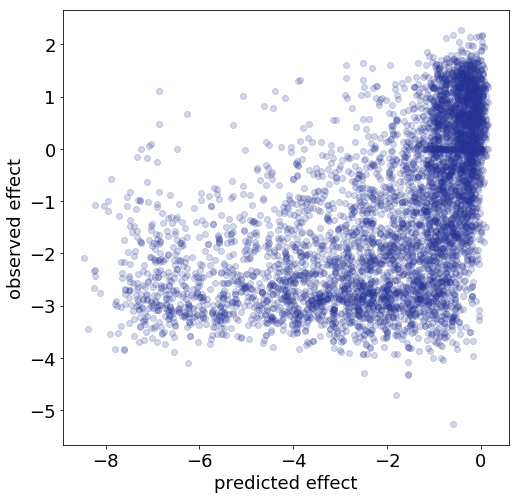

(0.55280619516533003, 0.0)

In [7]:
Kka2_2_data = data2.filter_by([x for x in data2['dms_id'].unique() if x in ['kka2_1:2']], 'dms_id')
Kka2_2_data2 = Kka2_2_data.filter_by([x for x in Kka2_2_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del Kka2_2_data2['id']
Kka2_2_data2 = Kka2_2_data2.add_row_number('id',0)
Kka2_2_data2['selection_coefficient'] = .4

pred = NoKka2_model.predict(Kka2_2_data2)
stats.pearsonr(pred, Kka2_2_data2['reported_fitness'])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,Kka2_2_data2['reported_fitness'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

stats.pearsonr(pred, Kka2_2_data2['reported_fitness'])
#stats.spearmanr(pred, Kka2_2_data2['reported_fitness'])
#sqrt(mean_squared_error(pred,Kka2_2_data2['reported_fitness']))

In [8]:
stats.spearmanr(pred, Kka2_2_data2['reported_fitness'])

SpearmanrResult(correlation=0.63719871624860369, pvalue=0.0)

/net/gs/vol3/software/modules-sw-python/2.7.3/matplotlib/2.0.2_4430-UCS4/Linux/RHEL6/x86_64/lib/python2.7/site-packages/matplotlib-2.0.2+4430.g2a7237c-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


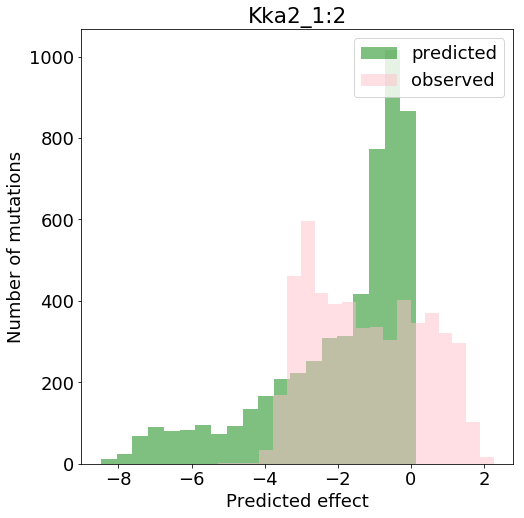

In [17]:
## histogram of predictions
num_bins = 20
# the histogram of the data
plt.hist(pred, num_bins, facecolor='green', alpha=0.5, label = "predicted")
plt.hist(Kka2_2_data2['reported_fitness'], num_bins, facecolor='pink', alpha=0.5,
        label = "observed")
plt.xlabel('Predicted effect')
plt.ylabel('Number of mutations')
plt.title(r'Kka2_1:2')
plt.legend(loc='upper right')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

In [18]:
params = dict([('target', 'reported_fitness'), ('max_depth', 5), ('max_iterations' , [10,25,50,100,250]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params1 = dict([('target', 'reported_fitness'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params2 = dict([('target', 'reported_fitness'), ('max_depth',6), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,50 ), 
               ('min_loss_reduction' , [0, 0.1, 0.2, 0.3, 0.4, 0.5]), ('step_size' , 0.1), ('features' , [predictors3])])

params3 = dict([('target', 'reported_fitness'), ('max_depth',2), ('max_iterations' , 50), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,25 ), 
               ('min_loss_reduction' ,  0.1), ('step_size' , 0.1), ('features' , [predictors3])])

In [ ]:
## PSD95pdz3 
NOPSD95pdz3_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['PSD95pdz3']], 'protein')
NOPSD95pdz3_data2 = NOPSD95pdz3_data.filter_by([x for x in NOPSD95pdz3_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOPSD95pdz3_data2['id']
NOPSD95pdz3_data2 = NOPSD95pdz3_data2.add_row_number('id',0)

folds = LeaveOneLabelOut(NOPSD95pdz3_data2['protein'])
lopo_folds = []
for train, test in folds:
    lopo_folds.append((NOPSD95pdz3_data2.filter_by(train,'id'), NOPSD95pdz3_data2.filter_by(test,'id')))
    
lopo_output_protein_PSD95pdz3 = gl.model_parameter_search.grid_search.create(lopo_folds, gl.boosted_trees_regression.create, params2)

In [ ]:
lopo_output_protein_PSD95pdz3.get_best_params()

In [14]:
## PSD95pdz3 
NOPSD95pdz3_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['PSD95pdz3']], 'protein')
NOPSD95pdz3_data2 = NOPSD95pdz3_data.filter_by([x for x in NOPSD95pdz3_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOPSD95pdz3_data2['id']
NOPSD95pdz3_data2 = NOPSD95pdz3_data2.add_row_number('id',0)
NoPSD95pdz3_model = gl.boosted_trees_regression.create(NOPSD95pdz3_data2, 'reported_fitness', features = predictors3, max_iterations = 250,
                                                   column_subsample = 0.6, row_subsample = 0.7,
                                                           min_child_weight = 50, min_loss_reduction = 0.1, step_size = 0.01, max_depth = 6)


PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 25680

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 0.048027     | 12.180682          | 10.681112            | 2.492846      | 2.389202        |

| 2         | 0.103833     | 12.167910          | 10.640118            | 2.477069      | 2.373548        |

| 3         | 0.154853     | 12.154932          | 10.577546            | 2.462413      | 2.358257        |

| 4         | 0.205321     | 12.131232          | 10.521778            | 2.447367      | 2.343220        |

| 5         | 0.246331     | 12.123408          | 10.481890            | 2.433547      | 2.329253        |

| 6         | 0.291829     | 12.116095          | 10.446239            | 2.419963      | 2.315553        |

| 11        | 0.529319     | 12.045107          | 10.286326            | 2.352864      | 2.249369        |

| 25        | 1.184571     | 11.879458          | 10.045977            | 2.180334      | 2.079779        |

| 50        | 2.340048     | 11.666510          | 9.562775             | 1.935056      | 1.834213        |

| 51        | 2.388915     | 11.658257          | 9.554522             | 1.926947      | 1.825763        |

| 75        | 3.482870     | 11.408744          | 9.161241             | 1.753657      | 1.656107        |

| 100       | 4.664243     | 11.232168          | 8.835216             | 1.621790      | 1.529252        |

| 101       | 4.719074     | 11.228736          | 8.811056             | 1.616871      | 1.524654        |

| 125       | 5.825615     | 11.101418          | 8.491843             | 1.522207      | 1.434553        |

| 150       | 6.960451     | 10.968854          | 8.246455             | 1.450022      | 1.367374        |

| 175       | 8.120549     | 10.867674          | 8.081028             | 1.396877      | 1.319421        |

| 200       | 9.228129     | 10.819860          | 7.782710             | 1.355399      | 1.282106        |

| 225       | 10.373590    | 10.723764          | 7.545925             | 1.320512      | 1.251019        |

| 250       | 11.494561    | 10.667054          | 7.278587             | 1.292624      | 1.224943        |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

In [19]:
PSD95pdz3_data2 = data2.filter_by([x for x in data2['dms_id'].unique() if x in ['PSD95pdz3']], 'dms_id')
PSD95pdz3_data2 = PSD95pdz3_data2.filter_by([x for x in PSD95pdz3_data2['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del PSD95pdz3_data2['id']
PSD95pdz3_data2 = PSD95pdz3_data2.add_row_number('id',0)
PSD95pdz3_data2['selection_coefficient'] = .4
pred = NoPSD95pdz3_model.predict(PSD95pdz3_data2)

In [21]:
stats.pearsonr(pred, PSD95pdz3_data2['reported_fitness'])

(0.3896683667969148, 2.4360649521991768e-58)

In [22]:
stats.spearmanr(pred, PSD95pdz3_data2['reported_fitness'])

SpearmanrResult(correlation=0.31367418560601945, pvalue=2.4040255225199281e-37)

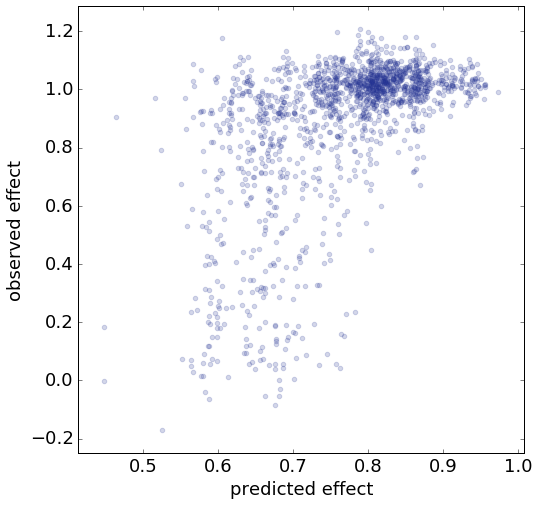

In [18]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,PSD95pdz3_data2['reported_fitness'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

In [88]:
pickler = gl._gl_pickle.GLPickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoPSD95pdz3_model_regressionModel_unnormalized_2017-08-01')
pickler.dump(NoPSD95pdz3_model)
pickler.close()

In [23]:
unpickler = gl._gl_pickle.GLUnpickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoPSD95pdz3_model_regressionModel_unnormalized_2017-08-01')
NoPSD95pdz3_model = unpickler.load()
unpickler.close()

In [36]:
params = dict([('target', 'reported_fitness'), ('max_depth', 5), ('max_iterations' , [10,25,50,100,250]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params1 = dict([('target', 'reported_fitness'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params2 = dict([('target', 'reported_fitness'), ('max_depth',2), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,50 ), 
               ('min_loss_reduction' , [0, 0.1, 0.2, 0.3, 0.4, 0.5]), ('step_size' , 0.1), ('features' , [predictors3])])

params3 = dict([('target', 'reported_fitness'), ('max_depth',2), ('max_iterations' , 50), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,50 ), 
               ('min_loss_reduction' ,  0.1), ('step_size' , 0.1), ('features' , [predictors3])])

In [37]:
## Pab1 
NOPab1_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['Pab1']], 'protein')
NOPab1_data2 = NOPab1_data.filter_by([x for x in NOPab1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOPab1_data2['id']
NOPab1_data2 = NOPab1_data2.add_row_number('id',0)

folds = LeaveOneLabelOut(NOPab1_data2['protein'])
lopo_folds = []
for train, test in folds:
    lopo_folds.append((NOPab1_data2.filter_by(train,'id'), NOPab1_data2.filter_by(test,'id')))
    
lopo_output_protein_Pab1 = gl.model_parameter_search.grid_search.create(lopo_folds, gl.boosted_trees_regression.create, params1)

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Feb-23-2017-15-46-2400000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Feb-23-2017-15-46-2400000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Feb-23-2017-15-46-2400000' already exists. Renaming the job to 'Model-Parameter-Search-Feb-23-2017-15-46-2400000-d4cef'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Feb-23-2017-15-46-2400000-d4cef' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Feb-23-2017-15-46-2400000-d4cef' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Feb-23-2017-15-46-2400001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Feb-23-2017-15-46

In [38]:
lopo_output_protein_Pab1.get_best_params()

{'column_subsample': 0.8,
 'features': ['aa1',
  'aa2',
  'wt_mut',
  'aa1_polarity',
  'aa2_polarity',
  'aa1_PI',
  'aa2_PI',
  'deltaPI',
  'Grantham',
  'aa1_weight',
  'aa2_weight',
  'deltaWeight',
  'aa1vol',
  'aa2vol',
  'deltavolume',
  'aa1_psic',
  'aa2_psic',
  'delta_psic',
  'accessibility',
  'dssp_sec_str',
  'phi_psi_reg',
  'delta_solvent_accessibility',
  'b_factor',
  'mut_msa_congruency',
  'mut_mut_msa_congruency',
  'seq_ind_closest_mut',
  'evolutionary_coupling_avg'],
 'max_depth': 6,
 'max_iterations': 50,
 'min_child_weight': 6,
 'min_loss_reduction': 0,
 'row_subsample': 0.8,
 'step_size': 0.1,
 'target': 'scaled_effect1'}

In [23]:
NOPab1_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['Pab1']], 'protein')
NOPab1_data2 = NOPab1_data.filter_by([x for x in NOPab1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOPab1_data2['id']
NOPab1_data2 = NOPab1_data2.add_row_number('id',0)

In [24]:

NoPab1_model = gl.boosted_trees_regression.create(NOPab1_data2, 'reported_fitness', features = predictors3, 
                                                  max_iterations = 250, column_subsample = 0.8, row_subsample = 0.8, 
                                                  min_child_weight = 6, min_loss_reduction = 0, step_size = 0.01, 
                                                  max_depth = 6)


PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 25946

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 0.069350     | 12.179750          | 10.703978            | 2.430188      | 2.486589        |

| 2         | 0.130340     | 12.165768          | 10.677484            | 2.414109      | 2.470664        |

| 3         | 0.188327     | 12.152489          | 10.639083            | 2.399808      | 2.456266        |

| 4         | 0.249388     | 12.139091          | 10.599234            | 2.384391      | 2.440814        |

| 5         | 0.308228     | 12.126431          | 10.550984            | 2.369279      | 2.425581        |

| 6         | 0.359823     | 12.117652          | 10.529700            | 2.354196      | 2.410368        |

| 11        | 0.614652     | 12.063583          | 10.352901            | 2.284385      | 2.340627        |

| 25        | 1.382525     | 11.921693          | 9.948265             | 2.104423      | 2.160775        |

| 50        | 2.758159     | 11.694866          | 9.435572             | 1.856364      | 1.909093        |

| 51        | 2.811754     | 11.687273          | 9.427671             | 1.847535      | 1.900018        |

| 75        | 4.118339     | 11.455284          | 8.979297             | 1.670469      | 1.721443        |

| 100       | 5.491490     | 11.241879          | 8.704713             | 1.532827      | 1.580786        |

| 101       | 5.548933     | 11.238408          | 8.690182             | 1.527779      | 1.575412        |

| 125       | 6.869103     | 11.059635          | 8.414770             | 1.431887      | 1.477759        |

| 150       | 8.257976     | 10.922001          | 8.184532             | 1.353281      | 1.394709        |

| 175       | 9.570426     | 10.820599          | 7.910275             | 1.296853      | 1.337531        |

| 200       | 10.946584    | 10.690989          | 7.740109             | 1.250475      | 1.291996        |

| 225       | 12.298476    | 10.592744          | 7.546127             | 1.215523      | 1.257981        |

| 250       | 13.679620    | 10.460012          | 7.336434             | 1.184680      | 1.229982        |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

In [41]:
pickler = gl._gl_pickle.GLPickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoPab1_model_regressionModel_unnormalized_2017-08-01')
pickler.dump(NoPab1_model)
pickler.close()

In [24]:
unpickler = gl._gl_pickle.GLUnpickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoPab1_model_regressionModel_unnormalized_2017-08-01')
NoPab1_model = unpickler.load()
unpickler.close()

In [26]:
## Pab1 
Pab1_data = data2.filter_by([x for x in data2['protein'].unique() if x in ['Pab1']], 'protein')
Pab1_data2 = Pab1_data.filter_by([x for x in Pab1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del Pab1_data2['id']
Pab1_data2 = Pab1_data2.add_row_number('id',0)

pred = NoPab1_model.predict(Pab1_data2)
stats.pearsonr(pred, Pab1_data2['reported_fitness'])

#sqrt(mean_squared_error(pred,Pab1_data2['reported_fitness']))

(0.38114572385301299, 2.2674331716821845e-42)

In [27]:
stats.spearmanr(pred, Pab1_data2['reported_fitness'])

SpearmanrResult(correlation=0.30338009653349396, pvalue=1.0303718283180552e-26)

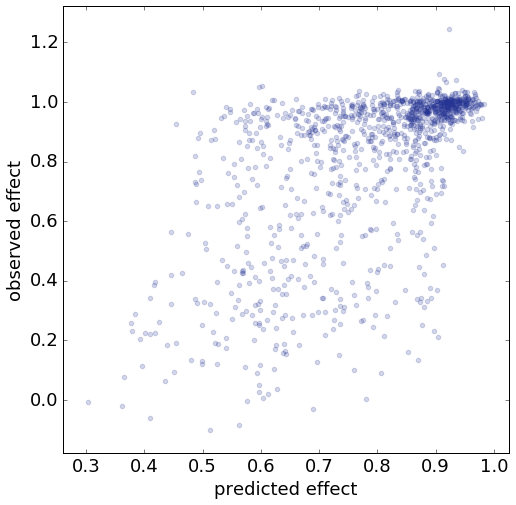

In [22]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,Pab1_data2['reported_fitness'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

In [43]:
## beta_lact 
NObeta_lact_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['TEM-1']], 'protein')
NObeta_lact_data2 = NObeta_lact_data.filter_by([x for x in NObeta_lact_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NObeta_lact_data2['id']
NObeta_lact_data2 = NObeta_lact_data2.add_row_number('id',0)

folds = LeaveOneLabelOut(NObeta_lact_data2['protein'])
lopo_folds = []
for train, test in folds:
    lopo_folds.append((NObeta_lact_data2.filter_by(train,'id'), NObeta_lact_data2.filter_by(test,'id')))


In [44]:
params = dict([('target', 'reported_fitness'), ('max_depth', 5), ('max_iterations' , [10,25,50,100,250]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params1 = dict([('target', 'reported_fitness'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params2 = dict([('target', 'reported_fitness'), ('max_depth',2), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,50 ), 
               ('min_loss_reduction' , [0, 0.1, 0.2, 0.3, 0.4, 0.5]), ('step_size' , 0.1), ('features' , [predictors3])])

params3 = dict([('target', 'reported_fitness'), ('max_depth',2), ('max_iterations' , 50), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,50 ), 
               ('min_loss_reduction' ,  0.3), ('step_size' , 0.1), ('features' , [predictors3])])

In [19]:
lopo_output_protein_beta_lact = gl.model_parameter_search.grid_search.create(lopo_folds, gl.boosted_trees_regression.create, params1)

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-01-2017-12-26-3700000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-01-2017-12-26-3700000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Aug-01-2017-12-26-3700000' already exists. Renaming the job to 'Model-Parameter-Search-Aug-01-2017-12-26-3700000-b017f'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-01-2017-12-26-3700000-b017f' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-01-2017-12-26-3700000-b017f' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-01-2017-12-26-3700001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-01-2017-12-26

In [46]:
lopo_output_protein_beta_lact.get_best_params()

{'column_subsample': 0.8,
 'features': ['aa1',
  'aa2',
  'wt_mut',
  'aa1_polarity',
  'aa2_polarity',
  'aa1_PI',
  'aa2_PI',
  'deltaPI',
  'Grantham',
  'aa1_weight',
  'aa2_weight',
  'deltaWeight',
  'aa1vol',
  'aa2vol',
  'deltavolume',
  'aa1_psic',
  'aa2_psic',
  'delta_psic',
  'accessibility',
  'dssp_sec_str',
  'phi_psi_reg',
  'delta_solvent_accessibility',
  'b_factor',
  'mut_msa_congruency',
  'mut_mut_msa_congruency',
  'seq_ind_closest_mut',
  'evolutionary_coupling_avg'],
 'max_depth': 2,
 'max_iterations': 50,
 'min_child_weight': 2,
 'min_loss_reduction': 0,
 'row_subsample': 0.8,
 'step_size': 0.1,
 'target': 'scaled_effect1'}

In [28]:
NObeta_lact_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['TEM-1']], 'protein')
NObeta_lact_data2 = NObeta_lact_data.filter_by([x for x in NObeta_lact_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NObeta_lact_data2['id']
NObeta_lact_data2 = NObeta_lact_data2.add_row_number('id',0)

In [29]:
## TEM-1
## beta_lact 
Nobeta_lact_model = gl.boosted_trees_regression.create(NObeta_lact_data2, 'reported_fitness', 
                                                       features = predictors3, max_iterations = 250,
                                                   column_subsample = 0.8, row_subsample = 0.8,
                                                           min_child_weight = 50, min_loss_reduction = 0.3, 
                                                       step_size = 0.01, max_depth = 6)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 22249

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 0.059652     | 12.182233          | 9.381773             | 1.673626      | 1.662490        |

| 2         | 0.105496     | 12.173531          | 9.373071             | 1.663713      | 1.652542        |

| 3         | 0.148439     | 12.163671          | 9.363211             | 1.653890      | 1.643142        |

| 4         | 0.197075     | 12.153821          | 9.353361             | 1.644140      | 1.633464        |

| 5         | 0.244580     | 12.143002          | 9.342541             | 1.634196      | 1.623541        |

| 6         | 0.291692     | 12.133758          | 9.333298             | 1.624244      | 1.613797        |

| 11        | 0.514540     | 12.086572          | 9.286112             | 1.577710      | 1.569159        |

| 25        | 1.161351     | 11.967279          | 9.162992             | 1.463814      | 1.458104        |

| 50        | 2.298919     | 11.788561          | 8.973718             | 1.304650      | 1.303786        |

| 51        | 2.345042     | 11.781532          | 8.966689             | 1.299456      | 1.298752        |

| 75        | 3.423367     | 11.637192          | 8.818310             | 1.190752      | 1.194247        |

| 100       | 4.578313     | 11.489359          | 8.681754             | 1.108121      | 1.114639        |

| 101       | 4.625348     | 11.481886          | 8.674281             | 1.105554      | 1.112142        |

| 125       | 5.721507     | 11.365104          | 8.544523             | 1.049417      | 1.058573        |

| 150       | 6.884652     | 11.230639          | 8.419708             | 1.006013      | 1.018386        |

| 175       | 8.033383     | 11.119173          | 8.310169             | 0.973749      | 0.990981        |

| 200       | 9.182605     | 11.029920          | 8.217182             | 0.948569      | 0.969183        |

| 225       | 10.329292    | 10.932771          | 8.133276             | 0.929889      | 0.954211        |

| 250       | 11.480226    | 10.877484          | 8.080998             | 0.914771      | 0.943684        |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

In [44]:
pickler = gl._gl_pickle.GLPickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/Nobeta_lact_model_regressionModel_unnormalized_2017-08-01')
pickler.dump(Nobeta_lact_model)
pickler.close()

In [26]:
unpickler = gl._gl_pickle.GLUnpickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/Nobeta_lact_model_regressionModel_unnormalized_2017-08-01')
Nobeta_lact_model = unpickler.load()
unpickler.close()

In [30]:
## beta_lact 
beta_lact_data = data2.filter_by([x for x in data2['protein'].unique() if x in ['TEM-1']], 'protein')
beta_lact_data2 = beta_lact_data.filter_by([x for x in beta_lact_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del beta_lact_data2['id']
beta_lact_data2 = beta_lact_data2.add_row_number('id',0)

pred = Nobeta_lact_model.predict(beta_lact_data2)
stats.pearsonr(pred, beta_lact_data2['reported_fitness'])

#sqrt(mean_squared_error(pred,beta_lact_data2['reported_fitness']))

(0.6493178299073078, 0.0)

In [32]:
stats.spearmanr(pred, beta_lact_data2['reported_fitness'])

SpearmanrResult(correlation=0.71185085082256516, pvalue=0.0)

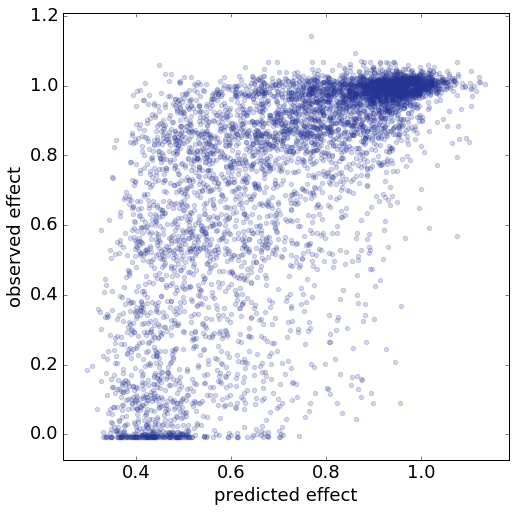

In [25]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,beta_lact_data2['reported_fitness'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

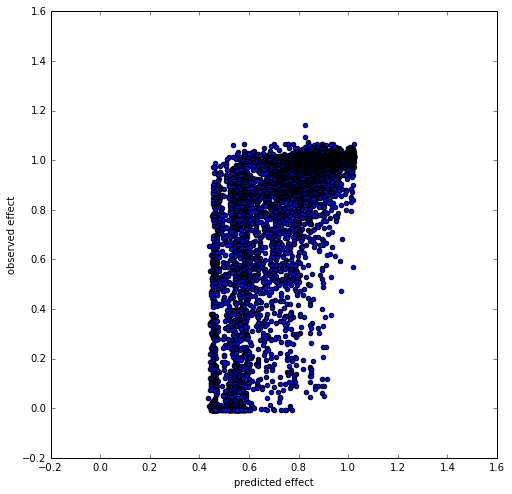

(0.64075281241660664, 0.0)

In [50]:
## beta_lactamase
beta_lact_data = data2.filter_by([x for x in data2['dms_id'].unique() if x in ['beta-lactamase']], 'dms_id')
beta_lact_data2 = beta_lact_data.filter_by([x for x in beta_lact_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del beta_lact_data2['id']
beta_lact_data2 = beta_lact_data2.add_row_number('id',0)

pred = Nobeta_lact_model.predict(beta_lact_data2)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([-0.2,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,beta_lact_data2['reported_fitness'])
plt.show()

stats.pearsonr(pred, beta_lact_data2['reported_fitness'])
#stats.spearmanr(pred, beta_lact_data2['reported_fitness'])
#sqrt(mean_squared_error(pred,beta_lact_data2['reported_fitness']))

In [ ]:
## Tack all of the beta-lact predictions onto a dataset

In [28]:
params = dict([('target', 'reported_fitness'), ('max_depth', 5), ('max_iterations' , [10,25,50,100,250]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params1 = dict([('target', 'reported_fitness'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

params2 = dict([('target', 'reported_fitness'), ('max_depth',6), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,25 ), 
               ('min_loss_reduction' , [0, 0.1, 0.2, 0.3, 0.4, 0.5]), ('step_size' , 0.1), ('features' , [predictors3])])

params3 = dict([('target', 'reported_fitness'), ('max_depth',2), ('max_iterations' , 50), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,2 ), 
               ('min_loss_reduction' ,  0.5), ('step_size' , 0.1), ('features' , [predictors3])])

In [29]:
## Uba1 
NOUba1_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['UBI4']], 'protein')
NOUba1_data2 = NOUba1_data.filter_by([x for x in NOUba1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOUba1_data2['id']
NOUba1_data2 = NOUba1_data2.add_row_number('id',0)

folds = LeaveOneLabelOut(NOUba1_data2['protein'])
lopo_folds = []
for train, test in folds:
    lopo_folds.append((NOUba1_data2.filter_by(train,'id'), NOUba1_data2.filter_by(test,'id')))
    
lopo_output_protein_Uba1 = gl.model_parameter_search.grid_search.create(lopo_folds, gl.boosted_trees_regression.create, params3)


[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Feb-24-2017-10-08-1000000' ready for execution


KeyboardInterrupt: 

In [ ]:
lopo_output_protein_Uba1.get_best_params()

In [33]:
## Uba1 
NOUba1_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['UBI4']], 'protein')
NOUba1_data2 = NOUba1_data.filter_by([x for x in NOUba1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOUba1_data2['id']
NOUba1_data2 = NOUba1_data2.add_row_number('id',0)
NoUba1_model = gl.boosted_trees_regression.create(NOUba1_data2, 'reported_fitness', features = predictors3, max_iterations = 250,
                                                   column_subsample = 0.8, row_subsample = 0.8,
                                                           min_child_weight = 25, min_loss_reduction = 0.5, step_size = 0.01, max_depth = 6)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 24800

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 0.066257     | 12.177208          | 10.686008            | 2.522591      | 2.438032        |

| 2         | 0.120139     | 12.165759          | 10.625843            | 2.505942      | 2.421267        |

| 3         | 0.175558     | 12.146713          | 10.580667            | 2.489076      | 2.406184        |

| 4         | 0.230551     | 12.132462          | 10.556244            | 2.472658      | 2.390025        |

| 5         | 0.284472     | 12.121674          | 10.503491            | 2.456164      | 2.374026        |

| 6         | 0.342567     | 12.108242          | 10.476030            | 2.439944      | 2.358107        |

| 11        | 0.602460     | 12.057923          | 10.355798            | 2.362790      | 2.286263        |

| 25        | 1.332956     | 11.919554          | 9.897039             | 2.170975      | 2.101831        |

| 50        | 2.654003     | 11.698656          | 9.335283             | 1.899872      | 1.844473        |

| 51        | 2.707043     | 11.692406          | 9.273572             | 1.890389      | 1.835732        |

| 75        | 3.973248     | 11.522786          | 8.792358             | 1.703033      | 1.661435        |

| 100       | 5.286933     | 11.334489          | 8.386603             | 1.560077      | 1.534028        |

| 101       | 5.335450     | 11.330850          | 8.327939             | 1.555131      | 1.529488        |

| 125       | 6.575928     | 11.197681          | 7.882183             | 1.454337      | 1.440718        |

| 150       | 7.900779     | 11.098236          | 7.672551             | 1.376305      | 1.375242        |

| 175       | 9.180395     | 10.992389          | 7.523137             | 1.319566      | 1.329990        |

| 200       | 10.478705    | 10.919513          | 7.403351             | 1.272988      | 1.291936        |

| 225       | 11.761146    | 10.842007          | 7.306540             | 1.236733      | 1.264903        |

| 250       | 13.068505    | 10.741508          | 7.166547             | 1.206686      | 1.243699        |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

In [47]:
pickler = gl._gl_pickle.GLPickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoUba1_model_regressionModel_unnormalized_2017-08-01')
pickler.dump(NoUba1_model)
pickler.close()

In [35]:
unpickler = gl._gl_pickle.GLUnpickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoUba1_model_regressionModel_unnormalized_2017-08-01')
NoUba1_model = unpickler.load()
unpickler.close()

In [34]:
## Uba1 
Uba1_data = data2.filter_by([x for x in data2['protein'].unique() if x in ['UBI4']], 'protein')
Uba1_data2 = Uba1_data.filter_by([x for x in Uba1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del Uba1_data2['id']
Uba1_data2 = Uba1_data2.add_row_number('id',0)

pred = NoUba1_model.predict(Uba1_data2)
stats.pearsonr(pred, Uba1_data2['reported_fitness'])
#stats.spearmanr(pred, Uba1_data2['reported_fitness'])
#sqrt(mean_squared_error(pred,Uba1_data2['reported_fitness']))

(0.50225751249768069, 2.0323650190875986e-149)

In [35]:
stats.spearmanr(pred, Uba1_data2['reported_fitness'])

SpearmanrResult(correlation=0.42461148191667697, pvalue=8.2034021275924309e-103)

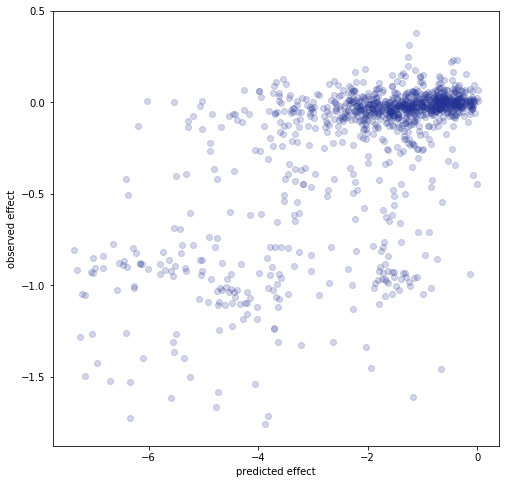

(0.62257818916342411, 1.8529749008559839e-117)

In [36]:
## ubiq_e1
ubiq_e1_data = data2.filter_by([x for x in data2['dms_id'].unique() if x in ['E1_Ubiquitin']], 'dms_id')
ubiq_e1_data2 = ubiq_e1_data.filter_by([x for x in ubiq_e1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del ubiq_e1_data2['id']
ubiq_e1_data2 = ubiq_e1_data2.add_row_number('id',0)

pred = NoUba1_model.predict(ubiq_e1_data2)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,ubiq_e1_data2['reported_fitness'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

stats.pearsonr(pred, ubiq_e1_data2['reported_fitness'])

#sqrt(mean_squared_error(pred,ubiq_e1_data2['reported_fitness']))

In [37]:
stats.spearmanr(pred, ubiq_e1_data2['reported_fitness'])

SpearmanrResult(correlation=0.51637633434663643, pvalue=5.4738129880105759e-75)

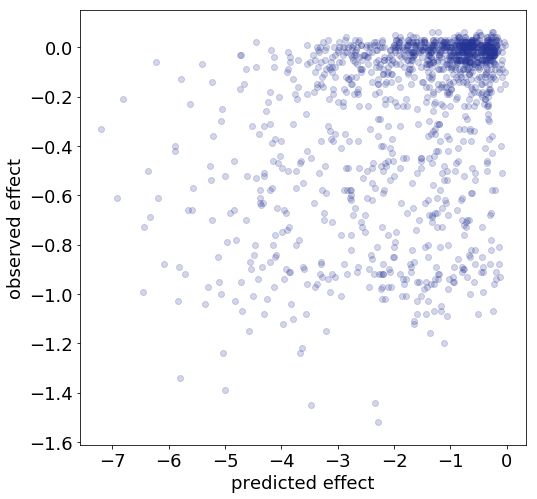

(0.38172460679861631, 1.3332392611125894e-44)

In [38]:
## ubiquitin
ubiq_data = data2.filter_by([x for x in data2['dms_id'].unique() if x in ['Ubiquitin']], 'dms_id')
ubiq_data2 = ubiq_data.filter_by([x for x in ubiq_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del ubiq_data2['id']
ubiq_data2 = ubiq_data2.add_row_number('id',0)

pred = NoUba1_model.predict(ubiq_data2)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,ubiq_data2['reported_fitness'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

stats.pearsonr(pred, ubiq_data2['reported_fitness'])

#sqrt(mean_squared_error(pred,ubiq_data2['reported_fitness']))

In [39]:
stats.spearmanr(pred, ubiq_data2['reported_fitness'])

SpearmanrResult(correlation=0.36264700728988253, pvalue=4.0845710181091085e-40)

In [21]:
params = dict([('target', 'reported_fitness'), ('max_depth', 5), ('max_iterations' , [10,25,50,100,250]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

In [22]:
params1 = dict([('target', 'reported_fitness'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

In [30]:
params2 = dict([('target', 'reported_fitness'), ('max_depth',6), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,25 ), 
               ('min_loss_reduction' , [0, 0.1, 0.2, 0.3, 0.4, 0.5]), ('step_size' , 0.1), ('features' , [predictors3])])

In [33]:
params3 = dict([('target', 'reported_fitness'), ('max_depth',6), ('max_iterations' , 50), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,25), 
               ('min_loss_reduction' ,  0.5), ('step_size' , 0.3), ('features' , [predictors3])])

In [6]:
## Yap65 
NOYap65_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['Yap65']], 'protein')
NOYap65_data2 = NOYap65_data.filter_by([x for x in NOYap65_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOYap65_data2['id']
NOYap65_data2 = NOYap65_data2.add_row_number('id',0)

folds = LeaveOneLabelOut(NOYap65_data2['protein'])
lopo_folds = []
for train, test in folds:
    lopo_folds.append((NOYap65_data2.filter_by(train,'id'), NOYap65_data2.filter_by(test,'id')))

In [40]:
## Yap65 
NOYap65_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['Yap65']], 'protein')
NOYap65_data2 = NOYap65_data.filter_by([x for x in NOYap65_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOYap65_data2['id']
NOYap65_data2 = NOYap65_data2.add_row_number('id',0)

In [34]:
lopo_output_protein_Yap65 = gl.model_parameter_search.grid_search.create(lopo_folds, gl.boosted_trees_regression.create, params3)


[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Feb-24-2017-10-29-5000000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Feb-24-2017-10-29-5000000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Feb-24-2017-10-29-5000000' already exists. Renaming the job to 'Model-Parameter-Search-Feb-24-2017-10-29-5000000-f374f'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Feb-24-2017-10-29-5000000-f374f' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Feb-24-2017-10-29-5000000-f374f' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Feb-24-2017-10-29-5000001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Feb-24-2017-10-29

In [35]:
lopo_output_protein_Yap65.get_best_params()

{'column_subsample': 0.6,
 'features': ['aa1',
  'aa2',
  'wt_mut',
  'aa1_polarity',
  'aa2_polarity',
  'aa1_PI',
  'aa2_PI',
  'deltaPI',
  'Grantham',
  'aa1_weight',
  'aa2_weight',
  'deltaWeight',
  'aa1vol',
  'aa2vol',
  'deltavolume',
  'aa1_psic',
  'aa2_psic',
  'delta_psic',
  'accessibility',
  'dssp_sec_str',
  'phi_psi_reg',
  'delta_solvent_accessibility',
  'b_factor',
  'mut_msa_congruency',
  'mut_mut_msa_congruency',
  'seq_ind_closest_mut',
  'evolutionary_coupling_avg'],
 'max_depth': 2,
 'max_iterations': 50,
 'min_child_weight': 10,
 'min_loss_reduction': 0.5,
 'row_subsample': 0.8,
 'step_size': 0.3,
 'target': 'scaled_effect1'}

In [41]:
## Yap65 
NoYap65_model = gl.boosted_trees_regression.create(NOYap65_data2, 'reported_fitness', features = predictors3, max_iterations = 250,
                                                   column_subsample = 0.6, row_subsample = 0.8,
                                                           min_child_weight = 50, min_loss_reduction = 1, step_size = 0.01, max_depth = 8)


PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 26742

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 0.080809     | 12.170993          | 10.695904            | 2.433225      | 2.377088        |

| 2         | 0.145214     | 12.158148          | 10.659573            | 2.416790      | 2.361226        |

| 3         | 0.214884     | 12.131985          | 10.628433            | 2.401450      | 2.346601        |

| 4         | 0.283798     | 12.120744          | 10.617592            | 2.387095      | 2.332833        |

| 5         | 0.356184     | 12.096797          | 10.601284            | 2.372742      | 2.319089        |

| 6         | 0.421165     | 12.089237          | 10.567676            | 2.358316      | 2.304727        |

| 11        | 0.765916     | 12.024569          | 10.401840            | 2.286016      | 2.234025        |

| 25        | 1.698329     | 11.812418          | 10.089505            | 2.104761      | 2.056388        |

| 50        | 3.296366     | 11.462347          | 9.542493             | 1.848054      | 1.810371        |

| 51        | 3.355351     | 11.455204          | 9.527140             | 1.838889      | 1.800972        |

| 75        | 4.965427     | 11.158169          | 9.028614             | 1.652292      | 1.623747        |

| 100       | 6.612794     | 10.921985          | 8.548016             | 1.509523      | 1.491691        |

| 101       | 6.670263     | 10.903390          | 8.535559             | 1.504858      | 1.487381        |

| 125       | 8.287069     | 10.701279          | 8.324076             | 1.398375      | 1.389832        |

| 150       | 9.881840     | 10.559029          | 8.088884             | 1.318035      | 1.316294        |

| 175       | 11.469175    | 10.444365          | 7.959422             | 1.257677      | 1.263481        |

| 200       | 13.047886    | 10.348691          | 7.829161             | 1.211246      | 1.223136        |

| 225       | 14.582010    | 10.211087          | 7.713038             | 1.171658      | 1.190406        |

| 250       | 16.213836    | 10.093599          | 7.628196             | 1.137849      | 1.161958        |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

In [31]:
pickler = gl._gl_pickle.GLPickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoYap65_model_regressionModel_unnormalized_2017-08-01')
pickler.dump(NoYap65_model)
pickler.close()

In [29]:
unpickler = gl._gl_pickle.GLUnpickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/NoYap65_model_regressionModel_unnormalized_2017-08-01')
NoYap65_model = unpickler.load()
unpickler.close()

In [42]:
## Yap65 
Yap65_data = data2.filter_by([x for x in data2['protein'].unique() if x in ['Yap65']], 'protein')
Yap65_data2 = Yap65_data.filter_by([x for x in Yap65_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del Yap65_data2['id']
Yap65_data2 = Yap65_data2.add_row_number('id',0)

pred = NoYap65_model.predict(Yap65_data2)
stats.pearsonr(pred, Yap65_data2['reported_fitness'])

#sqrt(mean_squared_error(pred,Yap65_data2['reported_fitness']))

(0.42518267834482182, 2.2793771082205614e-17)

In [43]:
stats.spearmanr(pred, Yap65_data2['reported_fitness'])

SpearmanrResult(correlation=0.34188789613199461, pvalue=2.1691876530628061e-11)

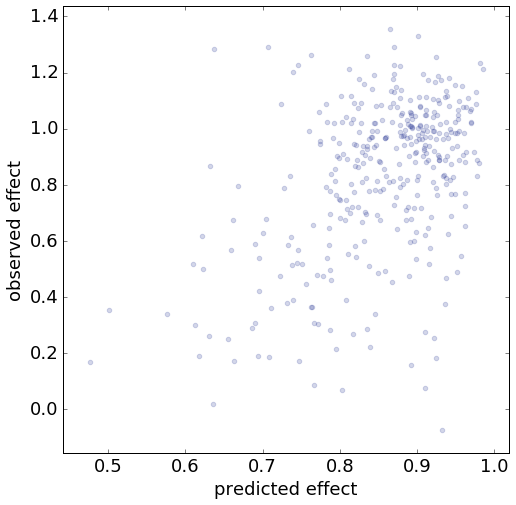

In [31]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,Yap65_data2['reported_fitness'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

In [42]:
params = dict([('target', 'reported_fitness'), ('max_depth', 5), ('max_iterations' , [10,25,50,100,250]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

In [5]:
params1 = dict([('target', 'reported_fitness'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

In [8]:
params2 = dict([('target', 'reported_fitness'), ('max_depth',6), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,6 ), 
               ('min_loss_reduction' , [0, 0.1, 0.2, 0.3, 0.4, 0.5]), ('step_size' , 0.1), ('features' , [predictors3])])

In [11]:
params3 = dict([('target', 'reported_fitness'), ('max_depth',6), ('max_iterations' , 50), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,6 ), 
               ('min_loss_reduction' ,  0.4), ('step_size' , 0.1), ('features' , [predictors3])])

In [12]:
NOhsp90_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['hsp90']], 'protein')
NOhsp90_data2 = NOhsp90_data.filter_by([x for x in NOhsp90_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOhsp90_data2['id']
NOhsp90_data2 = NOhsp90_data2.add_row_number('id',0)

folds = LeaveOneLabelOut(NOhsp90_data2['protein'])
lopo_folds = []
for train, test in folds:
    lopo_folds.append((NOhsp90_data2.filter_by(train,'id'), NOhsp90_data2.filter_by(test,'id')))

lopo_output_protein_hsp90 = gl.model_parameter_search.grid_search.create(lopo_folds, gl.boosted_trees_regression.create, params3)

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Feb-24-2017-13-02-4400000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Feb-24-2017-13-02-4400000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Feb-24-2017-13-02-4400000' already exists. Renaming the job to 'Model-Parameter-Search-Feb-24-2017-13-02-4400000-7b207'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Feb-24-2017-13-02-4400000-7b207' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Feb-24-2017-13-02-4400000-7b207' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Feb-24-2017-13-02-4400001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Feb-24-2017-13-02

In [13]:
lopo_output_protein_hsp90.get_best_params()

{'column_subsample': 0.6,
 'features': ['aa1',
  'aa2',
  'wt_mut',
  'aa1_polarity',
  'aa2_polarity',
  'aa1_PI',
  'aa2_PI',
  'deltaPI',
  'Grantham',
  'aa1_weight',
  'aa2_weight',
  'deltaWeight',
  'aa1vol',
  'aa2vol',
  'deltavolume',
  'aa1_psic',
  'aa2_psic',
  'delta_psic',
  'accessibility',
  'dssp_sec_str',
  'phi_psi_reg',
  'delta_solvent_accessibility',
  'b_factor',
  'mut_msa_congruency',
  'mut_mut_msa_congruency',
  'seq_ind_closest_mut',
  'evolutionary_coupling_avg'],
 'max_depth': 6,
 'max_iterations': 50,
 'min_child_weight': 6,
 'min_loss_reduction': 0.4,
 'row_subsample': 0.6,
 'step_size': 0.1,
 'target': 'scaled_effect1'}

In [44]:
## hsp90
NOhsp90_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['hsp90']], 'protein')
NOhsp90_data2 = NOhsp90_data.filter_by([x for x in NOhsp90_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOhsp90_data2['id']
NOhsp90_data2 = NOhsp90_data2.add_row_number('id',0)
Nohsp90_model = gl.boosted_trees_regression.create(NOhsp90_data2, 'reported_fitness', features = predictors3, max_iterations = 250,
                                                   column_subsample = 0.5, row_subsample = 0.5,
                                                           min_child_weight = 50, min_loss_reduction =0.9, step_size = 0.01, max_depth = 6)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 23290

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 0.066096     | 12.177237          | 10.681466            | 2.603036      | 2.538442        |

| 2         | 0.112056     | 12.167400          | 10.663464            | 2.586832      | 2.523375        |

| 3         | 0.156846     | 12.149690          | 10.612377            | 2.570550      | 2.507614        |

| 4         | 0.199578     | 12.134027          | 10.581495            | 2.556802      | 2.493886        |

| 5         | 0.245043     | 12.117828          | 10.550639            | 2.542966      | 2.480493        |

| 6         | 0.288545     | 12.099939          | 10.492953            | 2.527467      | 2.465435        |

| 11        | 0.494229     | 12.037616          | 10.325457            | 2.455610      | 2.396265        |

| 25        | 1.194081     | 11.899553          | 9.904946             | 2.273627      | 2.221860        |

| 50        | 2.530430     | 11.670578          | 9.301313             | 2.025157      | 1.987722        |

| 51        | 2.569708     | 11.655729          | 9.276752             | 2.018145      | 1.981039        |

| 75        | 3.546484     | 11.511330          | 8.990961             | 1.842519      | 1.820239        |

| 100       | 4.530898     | 11.345798          | 8.662379             | 1.707637      | 1.700248        |

| 101       | 4.574779     | 11.337694          | 8.652844             | 1.703299      | 1.696545        |

| 125       | 5.506411     | 11.229789          | 8.365823             | 1.608982      | 1.614722        |

| 150       | 6.503175     | 11.114511          | 8.109613             | 1.535276      | 1.551528        |

| 175       | 7.493901     | 11.009069          | 7.842256             | 1.477574      | 1.503413        |

| 200       | 8.434093     | 10.915462          | 7.656749             | 1.434805      | 1.468431        |

| 225       | 9.398897     | 10.860829          | 7.488612             | 1.402997      | 1.442501        |

| 250       | 10.359931    | 10.819881          | 7.383771             | 1.375107      | 1.419747        |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

In [35]:
pickler = gl._gl_pickle.GLPickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/Nohsp90_model_regressionModel_unnormalized_2017-08-01')
pickler.dump(Nohsp90_model)
pickler.close()

In [31]:
unpickler = gl._gl_pickle.GLUnpickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/Nohsp90_model_regressionModel_unnormalized_2017-08-01')
Nohsp90_model = unpickler.load()
unpickler.close()

In [46]:
## hsp90
hsp90_data = data2.filter_by([x for x in data2['protein'].unique() if x in ['hsp90']], 'protein')
hsp90_data2 = hsp90_data.filter_by([x for x in hsp90_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del hsp90_data2['id']
hsp90_data2 = hsp90_data2.add_row_number('id',0)

pred = Nohsp90_model.predict(hsp90_data2)
stats.pearsonr(pred, hsp90_data2['reported_fitness'])

#sqrt(mean_squared_error(pred,hsp90_data2['reported_fitness']))

(0.33690208533025784, 2.6851621397720309e-107)

In [47]:
stats.spearmanr(pred, hsp90_data2['reported_fitness'])

SpearmanrResult(correlation=0.29281620544509213, pvalue=2.5144669494171946e-80)

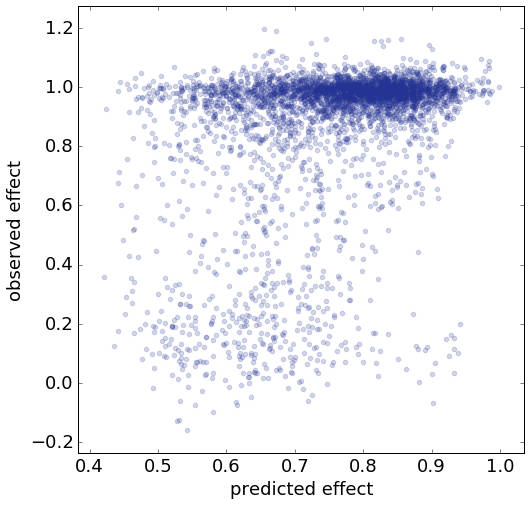

In [35]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,hsp90_data2['reported_fitness'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

In [ ]:
params = dict([('target', 'reported_fitness'), ('max_depth', 5), ('max_iterations' , [10,25,50,100,250]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

In [ ]:
params1 = dict([('target', 'reported_fitness'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

In [23]:
params2 = dict([('target', 'reported_fitness'), ('max_depth',6), ('max_iterations' , 50), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,25 ), 
               ('min_loss_reduction' , [0, 0.1, 0.2, 0.3, 0.4, 0.5]), ('step_size' , 0.1), ('features' , [predictors3])])

In [ ]:
params3 = dict([('target', 'reported_fitness'), ('max_depth',5), ('max_iterations' , 50), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,25 ), 
               ('min_loss_reduction' ,  0.5), ('step_size' , 0.1), ('features' , [predictors3])])

In [151]:
NOgb1_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['gb1']], 'protein')
NOgb1_data2 = NOgb1_data.filter_by([x for x in NOgb1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOgb1_data2['id']
NOgb1_data2 = NOgb1_data2.add_row_number('id',0)

folds = LeaveOneLabelOut(NOgb1_data2['protein'])
lopo_folds = []
for train, test in folds:
    lopo_folds.append((NOgb1_data2.filter_by(train,'id'), NOgb1_data2.filter_by(test,'id')))

In [5]:
NOgb1_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['gb1']], 'protein')
NOgb1_data2 = NOgb1_data.filter_by([x for x in NOgb1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOgb1_data2['id']
NOgb1_data2 = NOgb1_data2.add_row_number('id',0)
lopo_output_protein_gb1 = gl.model_parameter_search.grid_search.create(lopo_folds, gl.boosted_trees_regression.create, params3)

NameError: name 'lopo_folds' is not defined

In [25]:
lopo_output_protein_gb1.get_best_params()

{'column_subsample': 0.8,
 'features': ['aa1',
  'aa2',
  'wt_mut',
  'aa1_polarity',
  'aa2_polarity',
  'aa1_PI',
  'aa2_PI',
  'deltaPI',
  'Grantham',
  'aa1_weight',
  'aa2_weight',
  'deltaWeight',
  'aa1vol',
  'aa2vol',
  'deltavolume',
  'aa1_psic',
  'aa2_psic',
  'delta_psic',
  'accessibility',
  'dssp_sec_str',
  'phi_psi_reg',
  'delta_solvent_accessibility',
  'b_factor',
  'mut_msa_congruency',
  'mut_mut_msa_congruency',
  'seq_ind_closest_mut',
  'evolutionary_coupling_avg'],
 'max_depth': 6,
 'max_iterations': 50,
 'min_child_weight': 25,
 'min_loss_reduction': 0,
 'row_subsample': 0.8,
 'step_size': 0.1,
 'target': 'scaled_effect1'}

In [48]:
## gb1
NOgb1_data = data2.filter_by([x for x in data2['protein'].unique() if x not in ['gb1']], 'protein')
NOgb1_data2 = NOgb1_data.filter_by([x for x in NOgb1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del NOgb1_data2['id']
NOgb1_data2 = NOgb1_data2.add_row_number('id',0)

Nogb1_model = gl.boosted_trees_regression.create(NOgb1_data2, 'reported_fitness', features = predictors3, max_iterations = 250,
                                                   column_subsample = 0.8, row_subsample = 0.8,
                                                           min_child_weight = 50, min_loss_reduction = 0, step_size = 0.01, max_depth = 10)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 26109

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 0.119083     | 12.159155          | 10.678168            | 2.360919      | 2.475065        |

| 2         | 0.222543     | 12.131963          | 10.619591            | 2.344346      | 2.458274        |

| 3         | 0.331524     | 12.094272          | 10.570870            | 2.327810      | 2.441462        |

| 4         | 0.431881     | 12.074885          | 10.505744            | 2.310982      | 2.424179        |

| 5         | 0.536539     | 12.043165          | 10.442112            | 2.294414      | 2.407297        |

| 6         | 0.634397     | 12.034638          | 10.397224            | 2.278987      | 2.392262        |

| 10        | 1.052389     | 11.965805          | 10.246404            | 2.216202      | 2.328779        |

| 11        | 1.155353     | 11.953014          | 10.201670            | 2.200723      | 2.313899        |

| 20        | 2.088593     | 11.764572          | 9.730807             | 2.071720      | 2.183792        |

| 30        | 3.091570     | 11.570078          | 9.210922             | 1.943322      | 2.054689        |

| 40        | 4.092497     | 11.420249          | 8.797899             | 1.830912      | 1.944361        |

| 50        | 5.098047     | 11.257591          | 8.474593             | 1.731371      | 1.846225        |

| 51        | 5.196770     | 11.245529          | 8.431724             | 1.721462      | 1.836501        |

| 60        | 6.085240     | 11.103823          | 8.284003             | 1.639297      | 1.755629        |

| 70        | 7.098203     | 10.976155          | 8.180977             | 1.559990      | 1.677288        |

| 80        | 8.115370     | 10.837388          | 8.111336             | 1.490061      | 1.610417        |

| 90        | 9.139499     | 10.693333          | 8.034942             | 1.427027      | 1.551030        |

| 100       | 10.125018    | 10.614357          | 7.966006             | 1.371762      | 1.498505        |

| 101       | 10.232173    | 10.588848          | 7.961322             | 1.366008      | 1.493203        |

| 110       | 11.129231    | 10.484681          | 7.898296             | 1.321486      | 1.451813        |

| 120       | 12.132643    | 10.387543          | 7.834332             | 1.276402      | 1.410214        |

| 130       | 13.146686    | 10.276215          | 7.749080             | 1.235975      | 1.372824        |

| 140       | 14.160669    | 10.179894          | 7.682676             | 1.200856      | 1.341201        |

| 150       | 15.153511    | 10.117551          | 7.628521             | 1.168612      | 1.311460        |

| 160       | 16.131786    | 10.060520          | 7.606379             | 1.141384      | 1.288013        |

| 170       | 17.105537    | 10.001332          | 7.582048             | 1.116757      | 1.265684        |

| 180       | 18.092457    | 9.967796           | 7.558389             | 1.094879      | 1.247102        |

| 190       | 19.059828    | 9.897121           | 7.539142             | 1.075195      | 1.230882        |

| 200       | 20.037865    | 9.821077           | 7.508653             | 1.057498      | 1.216642        |

| 210       | 20.999241    | 9.789822           | 7.473248             | 1.041749      | 1.204134        |

| 220       | 21.962011    | 9.769321           | 7.455884             | 1.027126      | 1.192947        |

| 230       | 22.906529    | 9.740996           | 7.441755             | 1.014078      | 1.183328        |

| 240       | 23.833759    | 9.685472           | 7.416806             | 1.002083      | 1.174580        |

| 250       | 24.788567    | 9.665651           | 7.403157             | 0.991123      | 1.166023        |

+-----------+--------------+--------------------+----------------------+---------------+-----------------+

In [7]:
pickler = gl._gl_pickle.GLPickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/Nogb1_model_regressionModel_unnormalized_2017-08-01')
pickler.dump(Nogb1_model)
pickler.close()

In [33]:
unpickler = gl._gl_pickle.GLUnpickler(filename = '/net/fowler/vol1/home/vegray/metaDMS/dato/scaled/models/LOPO_models/Nogb1_model_regressionModel_unnormalized_2017-08-01')
Nogb1_model = unpickler.load()
unpickler.close()

In [49]:
## gb1
gb1_data = data2.filter_by([x for x in data2['protein'].unique() if x in ['gb1']], 'protein')
gb1_data2 = gb1_data.filter_by([x for x in gb1_data['mut_type'].unique() if x not in ['synonymous']], 'mut_type')
del gb1_data2['id']
gb1_data2 = gb1_data2.add_row_number('id',0)

pred = Nogb1_model.predict(gb1_data2)
stats.pearsonr(pred, gb1_data2['reported_fitness'])
#
#sqrt(mean_squared_error(pred,gb1_data2['reported_fitness']))

(0.36313925436483713, 6.3365115340560758e-34)

In [50]:
stats.spearmanr(pred, gb1_data2['reported_fitness'])

SpearmanrResult(correlation=0.29396631401361489, pvalue=2.8209489885134504e-22)

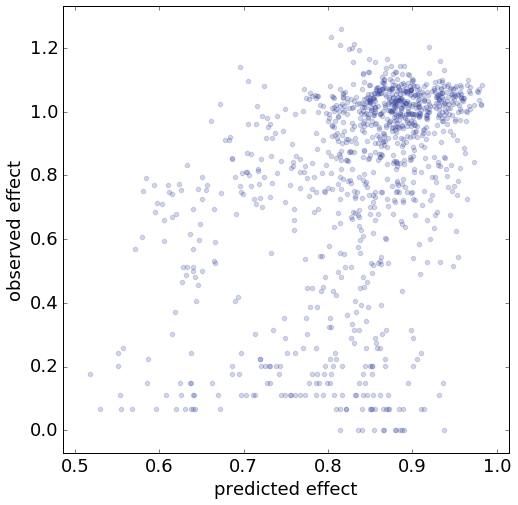

In [38]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('predicted effect')
ax.set_ylabel('observed effect')
ax.set_ylim([0,1.6])
ax.set_xlim([-0.2,1.6])
ax.scatter(pred,gb1_data2['reported_fitness'], alpha = 0.2, color = '#253494')
ax.axis('tight')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

In [50]:
data2['snap2score'] = data2['snap2score'].astype(int)

In [52]:
## SNAP PREDICTIONS
## ALL AA
data2.to_dataframe().groupby(['dms_id'])['reported_fitness', 'snap2score'].corr()

scaled_effect1  snap2score
dms_id                                                   
Brca1_E3       scaled_effect1        1.000000         NaN
               snap2score                 NaN         NaN
Brca1_Y2H      scaled_effect1        1.000000         NaN
               snap2score                 NaN         NaN
E1_Ubiquitin   scaled_effect1        1.000000   -0.260187
               snap2score           -0.260187    1.000000
E3_ligase      scaled_effect1        1.000000         NaN
               snap2score                 NaN         NaN
PSD95pdz3      scaled_effect1        1.000000   -0.369989
               snap2score           -0.369989    1.000000
Pab1           scaled_effect1        1.000000   -0.473339
               snap2score           -0.473339    1.000000
Ubiquitin      scaled_effect1        1.000000   -0.331440
               snap2score           -0.331440    1.000000
WW_domain      scaled_effect1        1.000000   -0.449136
               snap2score           -0.449136    1.000000
beta-lactamase scaled_effect1        1.000000   -0.619270
               snap2score           -0.619270    1.000000
gb1            scaled_effect1        1.000000   -0.175484
               snap2score           -0.175484    1.000000
hsp90          scaled_effect1        1.000000   -0.435641
               snap2score           -0.435641    1.000000
kka2_1:2       scaled_effect1        1.000000   -0.647184
               snap2score           -0.647184    1.000000

In [53]:
data2.to_dataframe().groupby(['dms_id'])['reported_fitness', 'snap2score'].corr(method = 'spearman')

scaled_effect1  snap2score
dms_id                                                   
Brca1_E3       scaled_effect1        1.000000         NaN
               snap2score                 NaN         NaN
Brca1_Y2H      scaled_effect1        1.000000         NaN
               snap2score                 NaN         NaN
E1_Ubiquitin   scaled_effect1        1.000000   -0.307250
               snap2score           -0.307250    1.000000
E3_ligase      scaled_effect1        1.000000         NaN
               snap2score                 NaN         NaN
PSD95pdz3      scaled_effect1        1.000000   -0.397588
               snap2score           -0.397588    1.000000
Pab1           scaled_effect1        1.000000   -0.553834
               snap2score           -0.553834    1.000000
Ubiquitin      scaled_effect1        1.000000   -0.381629
               snap2score           -0.381629    1.000000
WW_domain      scaled_effect1        1.000000   -0.474537
               snap2score           -0.474537    1.000000
beta-lactamase scaled_effect1        1.000000   -0.688730
               snap2score           -0.688730    1.000000
gb1            scaled_effect1        1.000000   -0.166484
               snap2score           -0.166484    1.000000
hsp90          scaled_effect1        1.000000   -0.443654
               snap2score           -0.443654    1.000000
kka2_1:2       scaled_effect1        1.000000   -0.638376
               snap2score           -0.638376    1.000000